# CuPyのテスト
ここでは，CuPyを使ってPythonからCUDAを呼び出し，GPUプログラミングを行う方法について確認していきます．
- 画像を用いたフーリエ変換での実行テスト

In [1]:
import numpy as np
import cupy as cp

from skimage import data,transform,color,io
import time

## 画像のロード

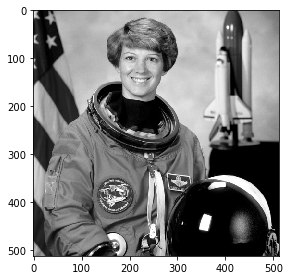

In [2]:
np_img = data.astronaut()#画像ロード

np_img = color.rgb2gray(np_img)#グレースケール化
np_img = np_img.astype('f')

io.imshow(np_img)#画像の表示

cp_img = cp.asarray(np_img)#numpy配列をcupy配列に変換

## Numpyを使った場合の処理速度計算

In [4]:
times_cpu = []  # CPUの計算時間保存用

for N in [10,100,1000,10000]:
    time_start = time.time()
    
    for i in range(N):
        sainokawara = np.fft.fft(np.fft.ifft(np.fft.fft(np_img)))
        
    time_end = time.time()
    elapsed_time = time_end - time_start  # 経過時間
    
    times_cpu.append(elapsed_time)

## CuPyを使った場合の処理速度計算

In [3]:
times_gpu = []  # GPUの計算時間保存用

for N in [10,100,1000,10000]:
    time_start = time.time()
    
    for i in range(N):
        sainokawara = cp.fft.fft(cp.fft.ifft(cp.fft.fft(cp_img)))
        
    time_end = time.time()
    elapsed_time = time_end - time_start  # 経過時間
    
    times_gpu.append(elapsed_time)

In [5]:
import tabulate

# N ごとの実行時間の差
N = [10, 100, 1000, 10000]
times_cpu = np.asarray(times_cpu)
times_gpu = np.asarray(times_gpu)

# tabulate を用いてテーブルを作成
table = tabulate.tabulate(
    zip(N, times_cpu, times_gpu),
    headers=['N', 'NumPyでの実行時間 (sec)', 'CuPy での実行時間 (sec)'])

print(table)

    N    NumPyでの実行時間 (sec)    CuPy での実行時間 (sec)
-----  -------------------------  -------------------------
   10                  0.0758278                 0.565878
  100                  0.731042                  0.00800729
 1000                  7.39322                   0.134057
10000                 74.5108                    1.57471


## CUDAのカーネル関数を直接定義して計算させる方法
1. 二つの正方行列の和を計算
2. CUDAの関数=カーネル関数？を自作して，同じ計算をさせてみる
3. 両者の比較

In [47]:
X = cp.arange(25).reshape(5, 5)
Y = cp.arange(25).reshape(5, 5)

# ありものの関数で計算
arimono = cp.add(X,Y)


# カーネル関数を定義、生成
mat_add_kernel = cp.ElementwiseKernel(
        in_params='int32 x, int32 y',
        out_params='float32 z',
        operation=\
        '''
        z = x + y;
        ''',
        name='mat_add_kernel')        # 関数名

# カーネル関数の呼び出し
Z = mat_add_kernel(X, Y)

print('cp.add = \n', arimono)
print('carnel = \n', Z)

cp.add = 
 [[ 0  2  4  6  8]
 [10 12 14 16 18]
 [20 22 24 26 28]
 [30 32 34 36 38]
 [40 42 44 46 48]]
carnel = 
 [[ 0.  2.  4.  6.  8.]
 [10. 12. 14. 16. 18.]
 [20. 22. 24. 26. 28.]
 [30. 32. 34. 36. 38.]
 [40. 42. 44. 46. 48.]]


# 添え字を使って配列の要素を参照する方法
- 引数の前にrawをつけることで，指定した引数に対してiという特殊変数が使用可能になる
- 該当の配列にのみ使えるっぽい

In [48]:
X = cp.zeros(25).reshape(5, 5).astype(cp.int16)
Y = cp.zeros_like(X) # yにあらかじめ出力の入れ物を用意
Z = cp.zeros_like(X) # yにあらかじめ出力の入れ物を用意

kernel = cp.ElementwiseKernel(
    in_params = 'raw int16 X, int16 shift, int16 width',  # x に raw を指定
    out_params = 'int16 Y, int16 Z', # 入力にraw指定があると出力も引数指定が求められます。
    operation=\
    '''
    Y = X[i]+shift;
    Z = i;
    ''',
    name='kernel')

kernel(X,2,X.shape[1],Y,Z) # 引数に出力も追加

print('Y = \n', Y)
print('Z = \n', Z)

Y = 
 [[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Z = 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


# 多次元配列の場合
- 行と列はこちらで工夫して定義する

In [51]:
X = cp.zeros(25).reshape(5, 5).astype(cp.int16)
Y = cp.arange(25).reshape(5,5).astype(cp.int16)
Z = cp.zeros_like(X) # yにあらかじめ出力の入れ物を用意

kernel = cp.ElementwiseKernel(
    in_params = 'int16 X, raw int16 Y, int16 width',  # x に raw を指定
    out_params = 'int16 Z', # 入力にraw指定があると出力も引数指定が求められます。
    operation=\
    '''
    int x_idx = i%width; 
    int y_idx = i/width;
    
    Z = y_idx*10 + x_idx;
    ''',
    name='kernel')

kernel(X,Y,X.shape[1],Z) # 引数に出力も追加

print('X[i] = \n', Y)
print('i = \n', Z)

X[i] = 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
i = 
 [[ 0  1  2  3  4]
 [10 11 12 13 14]
 [20 21 22 23 24]
 [30 31 32 33 34]
 [40 41 42 43 44]]


# 出力にrawを使う

In [85]:
X = cp.zeros(25).reshape(5, 5).astype(cp.int16)
Y = cp.arange(25).reshape(5,5).astype(cp.int16)
Z = cp.zeros_like(X) # yにあらかじめ出力の入れ物を用意
W = cp.zeros_like(X) # yにあらかじめ出力の入れ物を用意

kernel = cp.ElementwiseKernel(
    in_params = 'int16 X, int16 Y, int16 width',  # x に raw を指定
    out_params = 'raw int16 Z, raw int16 W',
    operation=\
    '''
    int x_idx = i%width; 
    int y_idx = i/width;
    
    Z[Y*2] = i;
    W[i*2] = Y;
    W[i*2-1] = Y;
    ''',
    name='kernel')

kernel(X,Y,X.shape[0],Z, W) # 引数に出力も追加

print('Z[Y] = i\n', Z)
print('W[i] = Y\n', W)

Z[Y] = i
 [[ 0  0  1  0  2]
 [ 0  3  0  4  0]
 [ 5  0  6  0  7]
 [ 0  8  0  9  0]
 [10  0 11  0 12]]
W[i] = Y
 [[ 0  1  1  2  2]
 [ 3  3  4  4  5]
 [ 5  6  6  7  7]
 [ 8  8  9  9 10]
 [10 11 11 12 12]]


# 入力と出力両方にraw

In [138]:
W = cp.arange(25).reshape(5, 5).astype(cp.int16)
x = cp.arange(5).astype(cp.int16)
W_new = cp.zeros_like(W) # yにあらかじめ出力の入れ物を用意

kernel = cp.ElementwiseKernel(
    in_params = 'raw int16 W, raw int16 x, int16 width',
    out_params = 'raw int16 W_new',
    operation=\
    '''
    int x_idx = i%width; 
    int y_idx = i/width;
    
    W_new[i] = x[y_idx]*x[x_idx] - x[y_idx]*x[y_idx]*W[i];
    ''',
    name='kernel')

kernel(W,x,W.shape[0],W_new, size=(W.shape[0] * W.shape[1])) # 引数に出力も追加

print('W_new[i] = i\n', W_new)

W_new[i] = i
 [[  0   0   0   0   0]
 [ -1   0   1   2   3]
 [ -4  -2   0   2   4]
 [ -9  -6  -3   0   3]
 [-16 -12  -8  -4   0]]


# CPUおよびGPUそれぞれでのhebbianの実装

## Numpy

In [99]:
%%time
# 変数
T = 500        # 入力時系列の長さ
N_x = 200      # 中間層の数
N_in = 1       # 入力層の数
N_out = 1      # 出力層の数
activation_func = np.tanh   # 活性化関数
learning_rate = 0.000001   # 可塑性の学習率
np.seed = np.random.seed(seed=0)

# 入力時系列データ
U = np.random.randn(T,1)

# 入力から中間層への結合重みの初期化
Win = np.random.uniform(-1,1,(N_x, N_in))

# 中間層の状態ベクトルの初期化
x = np.zeros(N_x)
W = np.random.uniform(-1,1,(N_x, N_x))

train_len = len(U)

# 時間発展
for n in range(train_len):
    x_in = np.dot(Win, U[n])
    x = x                  + activation_func(np.dot(W, x)                  + x_in)
        
    # リザバー結合重み行列の更新
    for post_neuron in range(N_x):
        W[post_neuron] += learning_rate * (x[post_neuron] * x         - np.square(x[post_neuron]) * W[post_neuron])
        
W_numpy = W

Wall time: 549 ms


In [111]:
W_numpy

array([[ 1.        ,  1.0416522 , -0.97339707, ...,  0.96318377,
        -0.94643827, -1.00387362],
       [ 0.96004257,  1.        , -0.93452209, ...,  0.92472435,
        -0.9086602 , -0.96375858],
       [-1.02734522, -1.07015964,  1.        , ..., -0.98950172,
         0.97228897,  1.03132693],
       ...,
       [ 1.0382538 ,  1.08153241, -1.0106121 , ...,  1.        ,
        -0.98260063, -1.04227867],
       [-1.05666139, -1.10072404,  1.02851893, ..., -1.01771458,
         1.        ,  1.06075918],
       [-0.99614162, -1.03762999,  0.96964333, ..., -0.9594702 ,
         0.94279056,  1.        ]])

## numpy to cupy
- NumpyとCuPyのseedが異なるため，Numpyで生成した配列をCuPy配列に変換し，処理結果が等しくなるか比較

In [101]:
%%time
kernel = cp.ElementwiseKernel(
    in_params = 'raw float64 W, raw float64 x, int16 width, float64 learning_rate',
    out_params = 'raw float64 W_new',
    operation=\
    '''
    int x_idx = i%width; 
    int y_idx = i/width;
    
    W_new[i] = learning_rate * (x[y_idx]*x[x_idx] - x[y_idx]*x[y_idx]*W[i]);
    ''',
    name='kernel')

# 変数
T = 500        # 入力時系列の長さ
N_x = 200      # 中間層の数
N_in = 1       # 入力層の数
N_out = 1      # 出力層の数
activation_func = cp.tanh   # 活性化関数
learning_rate = 0.000001   # 可塑性の学習率
np.seed = np.random.seed(seed=0)

# 入力時系列データ
U = np.random.randn(T,1)
U = cp.asarray(U)

# 入力から中間層への結合重みの初期化
Win = np.random.uniform(-1,1,(N_x, N_in))
Win = cp.asarray(Win)

# 中間層の状態ベクトルの初期化
x = cp.zeros(N_x)
W = np.random.uniform(-1,1,(N_x, N_x))
W = cp.asarray(W)

train_len = len(U)

W_new = cp.zeros_like(W)


for n in range(train_len):
    x_in = cp.dot(Win, U[n])
    x = x                  + activation_func(cp.dot(W, x)                  + x_in)
        
    # リザバー結合重み行列の更新
    W += kernel(W,x,W.shape[0], learning_rate, W_new, size=(W.shape[0] * W.shape[1])) # 引数に出力も追加
    
W_numcu = W

Wall time: 35.9 ms


In [105]:
W_numcu

array([[ 1.        ,  1.0416522 , -0.97339707, ...,  0.96318377,
        -0.94643827, -1.00387362],
       [ 0.96004257,  1.        , -0.93452209, ...,  0.92472435,
        -0.9086602 , -0.96375858],
       [-1.02734522, -1.07015964,  1.        , ..., -0.98950172,
         0.97228897,  1.03132693],
       ...,
       [ 1.0382538 ,  1.08153241, -1.0106121 , ...,  1.        ,
        -0.98260063, -1.04227867],
       [-1.05666139, -1.10072404,  1.02851893, ..., -1.01771458,
         1.        ,  1.06075918],
       [-0.99614162, -1.03762999,  0.96964333, ..., -0.9594702 ,
         0.94279056,  1.        ]])

# Cupy with kernel function

In [107]:
%%time
kernel = cp.ElementwiseKernel(
    in_params = 'raw float64 W, raw float64 x, int16 width, float64 learning_rate',
    out_params = 'raw float64 W_new',
    operation=\
    '''
    int x_idx = i%width; 
    int y_idx = i/width;
    
    W_new[i] = learning_rate * (x[y_idx]*x[x_idx] - x[y_idx]*x[y_idx]*W[i]);
    ''',
    name='kernel')

# 変数
T = 500        # 入力時系列の長さ
N_x = 200      # 中間層の数
N_in = 1       # 入力層の数
N_out = 1      # 出力層の数
activation_func = cp.tanh   # 活性化関数
learning_rate = 0.000001   # 可塑性の学習率
cp.seed = cp.random.seed(seed=0)

# 入力時系列データ
U = cp.random.randn(T,1)

# 入力から中間層への結合重みの初期化
Win = cp.random.uniform(-1,1,(N_x, N_in))

# 中間層の状態ベクトルの初期化
x = cp.zeros(N_x)

W = cp.random.uniform(-1,1,(N_x, N_x))

train_len = len(U)

W_new = cp.zeros_like(W)


for n in range(train_len):
    x_in = cp.dot(Win, U[n])
    x = x                  + activation_func(cp.dot(W, x)                  + x_in)
        
    # リザバー結合重み行列の更新
    W += kernel(W,x,W.shape[0], learning_rate, W_new, size=(W.shape[0] * W.shape[1])) # 引数に出力も追加
    
W_kernel = W

Wall time: 45.9 ms


In [109]:
W_kernel.shape

(200, 200)

# NumpyとCuPyでの速度比較

## Numpy

In [87]:
times_cpu = []


for N_x in [200,1000,2000]:
    time_start = time.time()
    # 変数
    T = 500        # 入力時系列の長さ
    #N_x = 200      # 中間層の数
    N_in = 1       # 入力層の数
    N_out = 1      # 出力層の数

    activation_func = np.tanh   # 活性化関数
    learning_rate = 0.000001   # 可塑性の学習率
    np.seed = np.random.seed(seed=0)

    # 入力時系列データ
    U = np.random.randn(T,1)

    # 入力から中間層への結合重みの初期化
    Win = np.random.uniform(-1,1,(N_x, N_in))

    # 中間層の状態ベクトルの初期化
    x = np.zeros(N_x)

    W = np.random.uniform(-1,1,(N_x, N_x))

    train_len = len(U)

    # 時間発展
    for n in range(train_len):
        x_in = np.dot(Win, U[n])
        x = x                  + activation_func(np.dot(W, x)                  + x_in)
        
        # リザバー結合重み行列の更新
        for post_neuron in range(N_x):
            W[post_neuron] += learning_rate * (x[post_neuron] * x         - np.square(x[post_neuron]) * W[post_neuron])

    W_numpy = W

    time_end = time.time()
    elapsed_time = time_end - time_start  # 経過時間
    
    times_cpu.append(elapsed_time)

## CuPy

In [90]:
times_gpu = []

kernel = cp.ElementwiseKernel(
    in_params = 'raw float64 W, raw float64 x, int16 width, float64 learning_rate',
    out_params = 'raw float64 W_new',
    operation=\
    '''
    int x_idx = i%width; // pre  synapse
    int y_idx = i/width; // post synapse
    
    W_new[i] = learning_rate * (x[y_idx]*x[x_idx] - x[y_idx]*x[y_idx]*W[i]);
    ''',
    name='kernel')


for N_x in [200,1000,2000]:
    time_start = time.time()
    # 変数
    T = 500        # 入力時系列の長さ
    #N_x = 200      # 中間層の数
    N_in = 1       # 入力層の数
    N_out = 1      # 出力層の数

    activation_func = cp.tanh   # 活性化関数
    learning_rate = 0.000001   # 可塑性の学習率
    cp.seed = cp.random.seed(seed=0)

    # 入力時系列データ
    U = cp.random.randn(T,1)

    # 入力から中間層への結合重みの初期化
    Win = cp.random.uniform(-1,1,(N_x, N_in))

    # 中間層の状態ベクトルの初期化
    x = cp.zeros(N_x)

    W = cp.random.uniform(-1,1,(N_x, N_x))

    train_len = len(U)

    W_new = cp.zeros_like(W)


    for n in range(train_len):
        x_in = cp.dot(Win, U[n])
        x = x                  + activation_func(cp.dot(W, x)                  + x_in)
        
        # リザバー結合重み行列の更新
        W += kernel(W,x,W.shape[0], learning_rate, W_new, size=(W.shape[0] * W.shape[1])) # 引数に出力も追加
    
    W_kernel = W
    time_end = time.time()
    elapsed_time = time_end - time_start  # 経過時間
    
    times_gpu.append(elapsed_time)

In [26]:
import tabulate

# N ごとの実行時間の差
T = [500,5000,44100]
times_cpu = np.asarray(times_cpu)
times_gpu = np.asarray(times_gpu)

# tabulate を用いてテーブルを作成
table = tabulate.tabulate(
    zip(T, times_cpu, times_gpu),
    headers=['T(length of input)', 'CPU での実行時間 (sec)', 'GPU での実行時間 (sec)'])

print(table)

  T(length of input)    CPU での実行時間 (sec)    GPU での実行時間 (sec)
--------------------  ------------------------  ------------------------
                 500                   0.55492                 0.0459044
                5000                   5.45988                 0.341088
               44100                  48.0563                  2.89725


In [30]:
import tabulate

# N ごとの実行時間の差
N = [200,1000,2000]
times_cpu = np.asarray(times_cpu)
times_gpu = np.asarray(times_gpu)

# tabulate を用いてテーブルを作成
table = tabulate.tabulate(
    zip(N, times_cpu, times_gpu),
    headers=['N(Size of reservoir)', 'CPU での実行時間 (sec)', 'GPU での実行時間 (sec)'])

print(table)

  N(Size of reservoir)    CPU での実行時間 (sec)    GPU での実行時間 (sec)
----------------------  ------------------------  ------------------------
                   200                  0.546414                  0.043911
                  1000                  3.61163                   0.123781
                  2000                  9.22988                   0.42386


In [68]:
cp.random.randn(10,1)

array([[-0.25762396],
       [-0.6070544 ],
       [-1.27999867],
       [ 0.41298924],
       [ 0.50872844],
       [-0.1049623 ],
       [-1.29358053],
       [ 3.11968608],
       [ 0.49960838],
       [-0.68910654]])

In [84]:
X = cp.arange(25).reshape(5, 5)
Y = cp.arange(25).reshape(5, 5)

# ありものの関数で計算
arimono = cp.add(X,Y)


# カーネル関数を定義、生成
hoge = cp.ElementwiseKernel(
        in_params='int32 x, int32 y',
        out_params='float32 z',
        operation=\
        '''
        z = x + y;
        ''',
        name='fuga')        # 関数名

# カーネル関数の呼び出し
Z = hoge(X, Y)

print('cp.add = \n', arimono)
print('carnel = \n', Z)

cp.add = 
 [[ 0  2  4  6  8]
 [10 12 14 16 18]
 [20 22 24 26 28]
 [30 32 34 36 38]
 [40 42 44 46 48]]
carnel = 
 [[ 0.  2.  4.  6.  8.]
 [10. 12. 14. 16. 18.]
 [20. 22. 24. 26. 28.]
 [30. 32. 34. 36. 38.]
 [40. 42. 44. 46. 48.]]
